In [13]:
from zipfile import ZipFile
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from geopandas import GeoDataFrame
from descartes import PolygonPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [14]:
from geopy.distance import geodesic

In [15]:
import pandas as pd
import zipfile
import re
import os 

os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Data')

# Loading incident data 
zf = zipfile.ZipFile('Data_incidents.csv.zip') 
df = pd.read_csv('Data_incidents.csv.zip')


In [16]:
# Loading law data 
df_law = pd.read_csv('gun_law_merge.csv', sep = ';')

# Renaming the state column
df_law.rename(columns={'Unnamed: 0':'state'}, inplace=True)

In [9]:
#import fiona; help(fiona.open)

In [17]:
# Loading map data 

os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/maps/states_21basic')

usa = gpd.read_file('states.shp')
usa.head(2)
#len(usa.STATE_NAME.unique())

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."


### Grouping the incident data by sum and count depending on what we want

In [19]:
df_group_count=df.groupby('state').count().reset_index()
df_group_incidents_count = df_group_count[['state','incident_id']]
df_group_sum = df.groupby('state').sum().reset_index()
df_group_incidents_sum = df_group_sum[['state','n_killed','n_injured']]
df_group_incidents_sum.head(1)

# Dataset with N_incident, n_killed and n_injured
df_group_incidents = df_group_incidents_sum.set_index('state').join(df_group_incidents_count.set_index('state')).reset_index()

### Grouping the incident data by number of true in incident characteristics

In [52]:
df_IC = df.iloc[:, [2] + list(range(19,128))]
df_IC_group = df_IC.groupby('state').sum().reset_index()

for col in df_IC.columns: 
    print(col)

state
Shot - Wounded/Injured
Mass Shooting
Possession
Possession of gun by felon or prohibited person
Shot - Dead
Gang involvement
Shots Fired - No Injuries
Bar/club incident - in or around establishment
Officer Involved Incident
Officer Involved Shooting - subject/suspect/perpetrator killed
Drug involvement
Kidnapping/abductions/hostage
Under the influence of alcohol or drugs
Suicide
Murder/Suicide
Attempted Murder/Suicide
Domestic Violence
Home Invasion
Home Invasion - Resident killed
Armed robbery with injury/death and/or evidence of DGU found
Drive-by
Officer Involved Shooting - Officer shot
Officer Involved Shooting - Officer killed
Officer Involved Shooting - subject/suspect/perpetrator shot
Officer Involved Shooting - subject/suspect/perpetrator suicide at standoff
Spree Shooting
Institution/Group/Business
Animal shot/killed
Home Invasion - Resident injured
Mass Murder
Concealed Carry License - Perpetrator
Stolen/Illegally owned
School Incident
School Shooting - university/colle

### Editing law data

In [50]:
laws =['State permit required to purchase? - Long guns',
'Firearm registration? - Long guns',
'Owner license required? - Long guns',
'Assault weapon law? - Long guns',
'NFA weapons restricted? - Long guns',
'Background checks required for private sales? - Long guns',
'Magazine Capacity Restriction? - Long guns',
'Red flag law? - Long guns',
'State permit required to purchase? - Handguns',
'Firearm registration? - Handguns',
'Owner license required? - Handguns',
'Assault weapon law? - Handguns',
'NFA weapons restricted? - Handguns',
'Background checks required for private sales? - Handguns',
'Magazine Capacity Restriction? - Handguns',
'Red flag law? - Handguns']

laws_longguns = laws[0:8]
laws_handguns = laws[8:16]

print(len(laws_longguns))
print(len(laws_handguns))


#count how many laws on handguns and longgund each state has

df_law['handgun_laws - count'] = df_law.loc[:, laws_handguns].sum(axis=1)
df_law['longgun_laws - count'] = df_law.loc[:, laws_longguns].sum(axis=1)
df_law.head(1)

8
8


,state,State permit required to purchase? - Long guns,Firearm registration? - Long guns,Owner license required? - Long guns,Assault weapon law? - Long guns,NFA weapons restricted? - Long guns,Background checks required for private sales? - Long guns,Magazine Capacity Restriction? - Long guns,Red flag law? - Long guns,State permit required to purchase? - Handguns,Firearm registration? - Handguns,Owner license required? - Handguns,Assault weapon law? - Handguns,NFA weapons restricted? - Handguns,Background checks required for private sales? - Handguns,Magazine Capacity Restriction? - Handguns,Red flag law? - Handguns,handgun_laws - count,longgun_laws - count
0,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Merging the map data, incident data and law data

In [53]:
merged_group = usa.set_index('STATE_NAME').join(df_group_incidents.set_index('state')).reset_index()
merged_group_all = merged_group.set_index('STATE_NAME').join(df_IC_group.set_index('state')).join(df_law.set_index('state'))

# Renaming incident_id to N_incident
merged_group_all.rename(columns={'incident_id':'N_incident'}, inplace=True)

In [54]:
merged_group_all['NFA weapons restricted? - Handguns']
merged_group_all[['N_incident','n_killed', 'n_injured','Child injured','Mass Shooting', 'Child killed self','Hate crime','NFA weapons restricted? - Handguns']].describe()
#merged_group_all[['N_incident','n_killed', 'n_injured','Child injured','Mass Shooting', 'Child killed self','Hate crime','NFA weapons restricted? - Handguns']].sum()

,N_incident,n_killed,n_injured,Child injured,Mass Shooting,Child killed self,Hate crime,NFA weapons restricted? - Handguns
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,4886.916667,1236.958333,2408.958333,21.354167,28.395833,3.395833,2.083333,0.229167
std,4306.499106,1255.456482,2567.264186,22.423857,34.526425,4.098467,2.981027,0.424744
min,472.000000,57.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1648.250000,276.750000,663.250000,4.000000,4.000000,0.000000,0.000000,0.000000
50%,3439.500000,853.500000,1442.500000,11.000000,14.000000,2.000000,1.000000,0.000000
75%,6699.250000,1720.000000,3539.250000,39.250000,39.750000,5.250000,2.250000,0.000000
max,17538.000000,5516.000000,13436.000000,83.000000,157.000000,19.000000,15.000000,1.000000


,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry,n_killed,n_injured,N_incident,Shot - Wounded/Injured,Mass Shooting,...,State permit required to purchase? - Handguns,Firearm registration? - Handguns,Owner license required? - Handguns,Assault weapon law? - Handguns,NFA weapons restricted? - Handguns,Background checks required for private sales? - Handguns,Magazine Capacity Restriction? - Handguns,Red flag law? - Handguns,handgun_laws - count,longgun_laws - count
STATE_NAME,,,,,,,,,,,,,,,,,,,,,
Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497...",NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,6.0,5.0
Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628...",845.0,1275.0,3430.0,1034.0,15.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,5.0,5.0
Montana,3,30,Mountain,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6...",154.0,136.0,638.0,113.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Maine,4,23,New England,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ...",112.0,132.0,907.0,104.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
North Dakota,5,38,West North Central,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939...",69.0,130.0,573.0,112.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
South Dakota,6,46,West North Central,SD,"POLYGON ((-102.78838 42.99530, -103.00588 42.9...",90.0,114.0,544.0,94.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wyoming,7,56,Mountain,WY,"POLYGON ((-104.05362 41.69822, -104.05550 41.5...",73.0,52.0,494.0,46.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wisconsin,8,55,East North Central,WI,"MULTIPOLYGON (((-87.74856 44.96162, -87.83999 ...",862.0,2113.0,4786.0,1778.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Idaho,9,16,Mountain,ID,"POLYGON ((-117.02630 43.67903, -117.02379 43.7...",166.0,149.0,661.0,131.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


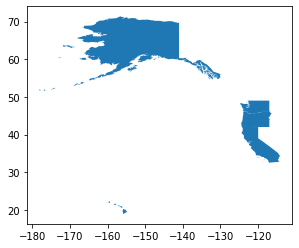

In [79]:
## Code for plotting specific regions (can also be used for states etc)
merged_group[merged_group.SUB_REGION == 'Pacific'].plot()
merged_group_all

## Plotting point map

### Excluiding Alaska and Hawaii from the map

df = df.drop(df[(df.state == 'Alaska') & (df.state == 'Hawaii')].index)


df_49 = df.drop(df.index[(df.state == 'Alaska')])
df_48 = df_49.drop(df_49.index[(df_49.state == 'Hawaii')])
df_47 = df_48.drop(df_48.index[(df_48.state == 'District of Columbia')])
print(len(df))
print(len(df_49))
print(len(df_48))
print(len(df_47))

In [57]:
df_47.state.unique()

array(['Michigan', 'New Jersey', 'New York', 'Missouri', 'Georgia',
       'Kentucky', 'Virginia', 'Pennsylvania', 'South Carolina',
       'Maryland', 'Delaware', 'Colorado', 'Alabama', 'Louisiana', 'Utah',
       'Indiana', 'Illinois', 'Texas', 'Nebraska', 'Massachusetts',
       'Florida', 'Mississippi', 'Wisconsin', 'Arizona', 'Washington',
       'Ohio', 'Kansas', 'West Virginia', 'New Hampshire', 'Rhode Island',
       'North Carolina', 'California', 'Oklahoma', 'Connecticut', 'Iowa',
       'Arkansas', 'Tennessee', 'Nevada', 'Minnesota', 'Idaho', 'Oregon',
       'Wyoming', 'Maine', 'North Dakota', 'New Mexico', 'Montana',
       'Vermont', 'South Dakota'], dtype=object)

In [58]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

In [59]:
crs = {'init': 'epsg:4269'}
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)
geo_df.head(1)

,Unnamed: 0,incident_id,state,city_or_county,n_killed,n_injured,incident_characteristics,latitude,location_description,longitude,...,Child injured,Gun buy back action,Terrorism Involvement,Officer Involved Shooting - Accidental discharge - no injury required,Mistaken ID,Officer Involved Shooting - subject/suspect/perpetrator suicide by cop,Ghost gun,Political Violence,NAV,geometry
0,0,95289,Michigan,Muskegon,0,0,Shots Fired - No Injuries,43.2301,NaN,-86.2514,...,False,False,False,False,False,False,False,False,False,POINT (-86.25140 43.23010)


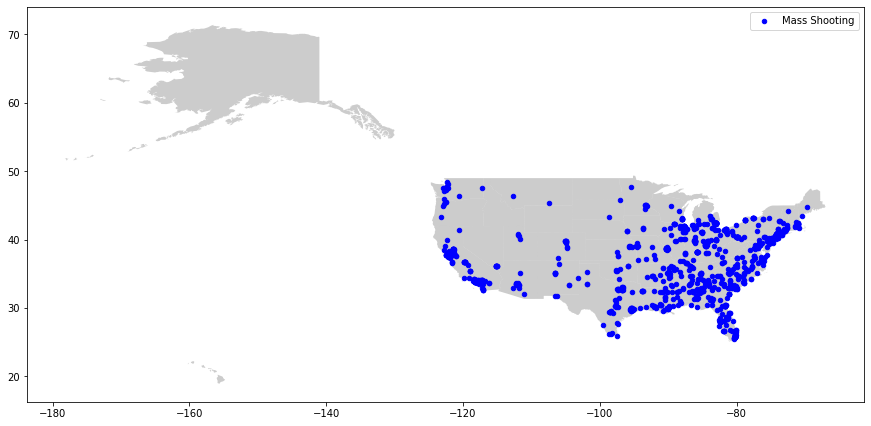

In [60]:
fig, ax = plt.subplots(figsize = (15,15))
usa.plot(ax = ax, alpha = 0.4, color = 'grey')
geo_df[geo_df['Mass Shooting']==True].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Mass Shooting')
#geo_df[geo_df['incident_id']>= 0].plot(ax = ax, markersize = 20, color = 'red', marker = 'o', label = 'Incident')
plt.legend()

## Plotting Heatmap with points

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


(22.5, 50)

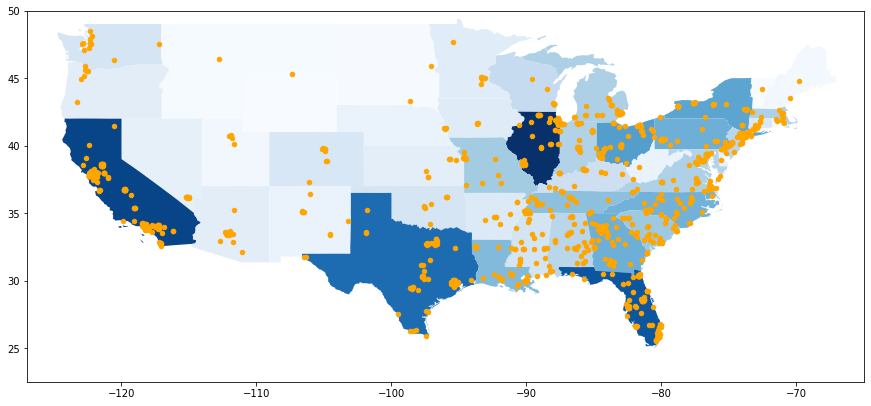

In [72]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'N_incident'

# set the range for the choropleth
vmin, vmax = 472, 17556

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 15))
merged_group_all.plot(column=variable, cmap='Blues', linewidth=0.8, ax = ax)
geo_df[geo_df['Mass Shooting']==True].plot(ax = ax, markersize = 20, color = 'orange', marker = 'o', label = 'Mass Shooting')

plt.xlim(right = -65)
plt.xlim(left = -127)
plt.ylim(bottom = 22.5)
plt.ylim(top = 50)

In [75]:
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.00)


# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig.colorbar(sm, cax=cax)

# add legend

In [94]:
os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')

fig.savefig("Incidents_figure.pdf", bbox_inches='tight')

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


(22.5, 50)

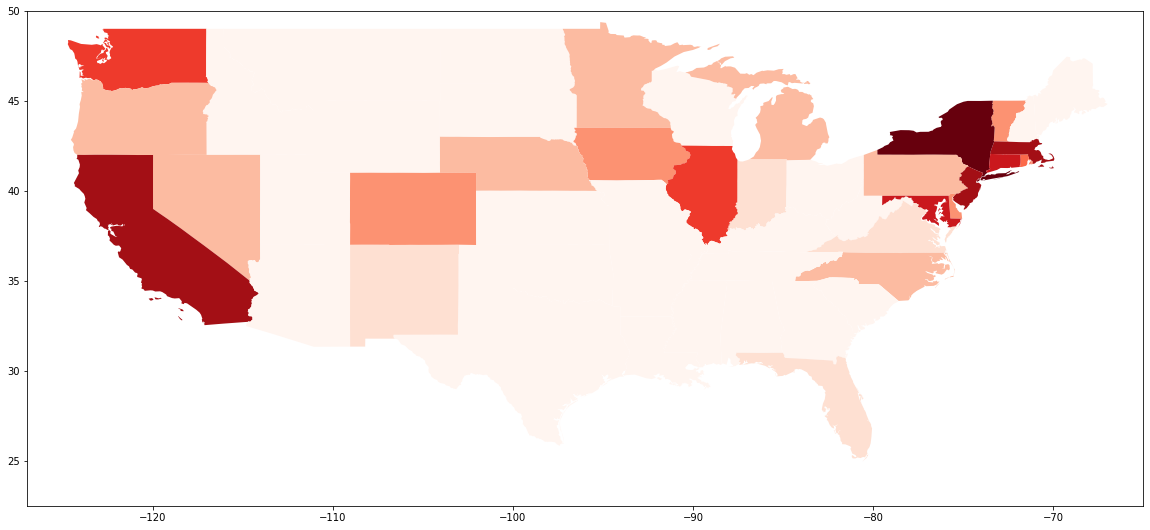

In [87]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'handgun_laws - count'

# set the range for the choropleth
vmin, vmax = 0, 8

# create figure and axes for Matplotlib
fig_law, ax = plt.subplots(1, figsize=(20, 15))
merged_group_all.plot(column=variable, cmap='Reds', linewidth=0.8, ax = ax)
plt.xlim(right = -65)
plt.xlim(left = -127)
plt.ylim(bottom = 22.5)
plt.ylim(top = 50)

In [88]:
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.00)


# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig.colorbar(sm, cax=cax)

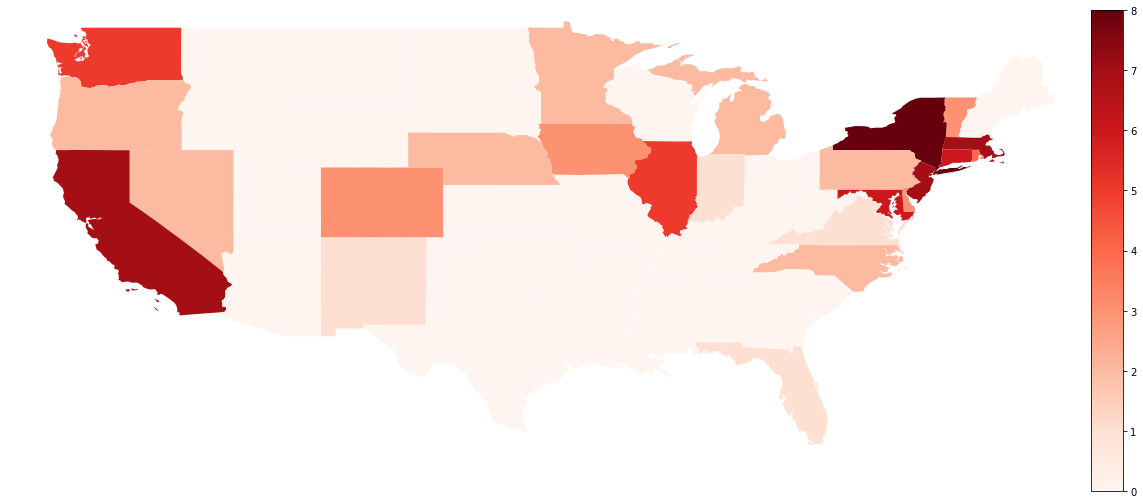

In [89]:
fig_law

In [96]:
fig_law.savefig("law_figure.pdf", bbox_inches='tight')